In [1]:
!pip install mne==1.7.1
!pip install PyWavelets
!pip install scipy

In [2]:
import mne
import numpy as np
import pandas as pd
import pywt
from pywt import wavedec
import scipy.stats as stats

In [3]:
raw = mne.io.read_raw_edf("1-2.edf", preload=True)
print(raw.info)

Extracting EDF parameters from /home/xilinx/jupyter_notebooks/VHDL_linear_algebra/DWT/1-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307199  =      0.000 ...   599.998 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fz, Cz, C3, C4, Pz, Cam-Sync, PVT, EOG-V, EOG-H, EMG, ECG
 chs: 11 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2014-11-27 03:33:59 UTC
 nchan: 11
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>


In [4]:
# Sélectionner les 5 premiers canaux EEG
#r=raw.pick_channels(raw.ch_names[:5])

Using matplotlib as 2D backend.


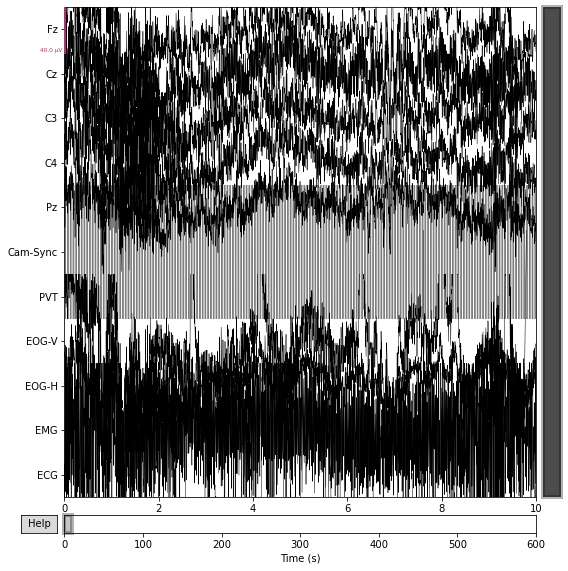

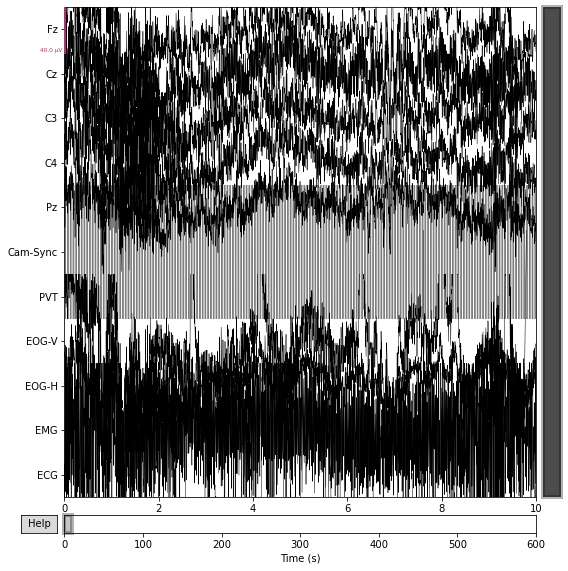

In [5]:
raw.plot()

In [6]:
%%time
rf = raw.filter(0.1,30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16897 samples (33.002 s)

CPU times: user 6.36 s, sys: 851 ms, total: 7.21 s
Wall time: 7.21 s


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0xa1512610>
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/transforms.py", line 222, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


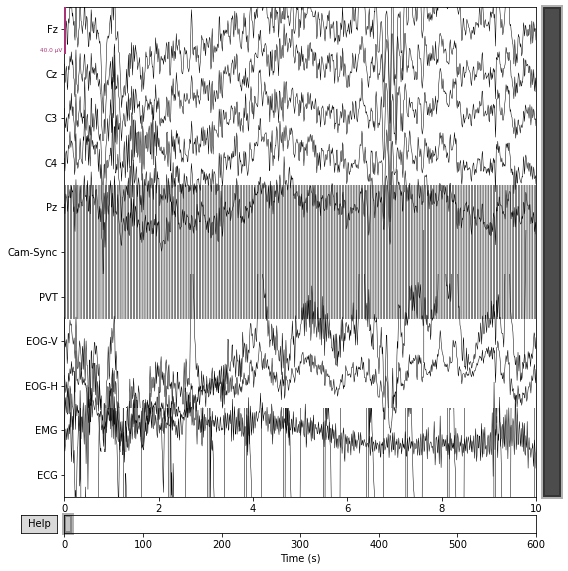

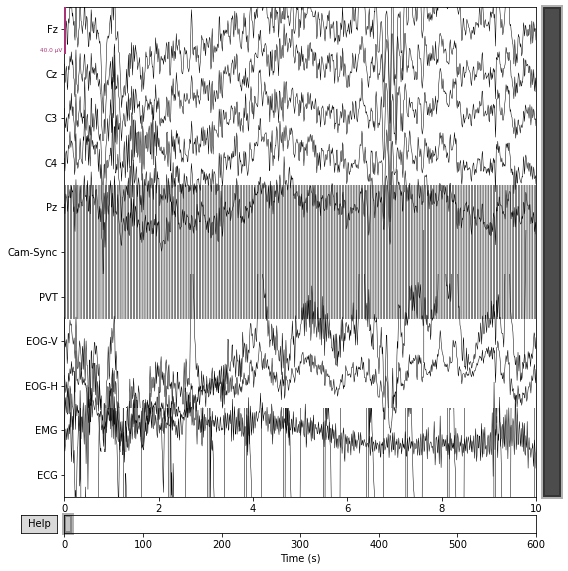

In [7]:
rf.plot()

In [8]:
print(rf.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, Cz, C3, C4, Pz, Cam-Sync, PVT, EOG-V, EOG-H, EMG, ECG
 chs: 11 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 30.0 Hz
 meas_date: 2014-11-27 03:33:59 UTC
 nchan: 11
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>


In [9]:
selected_channel_name = rf.info['ch_names']
sample_frequency = rf.info['sfreq']
epoch_duration = 10

In [10]:
selected_channel_name

['Fz',
 'Cz',
 'C3',
 'C4',
 'Pz',
 'Cam-Sync',
 'PVT',
 'EOG-V',
 'EOG-H',
 'EMG',
 'ECG']

In [11]:
sample_frequency

512.0

In [12]:
epoch_samples = int(epoch_duration*sample_frequency)

In [13]:
epoch_samples

5120

In [14]:
total_epochs = 307200// epoch_samples

In [15]:
total_epochs

60

In [16]:
epochs_matrix = np.zeros((total_epochs, 5, epoch_samples))  # 5 channels

In [17]:
# Segmenter les données en epochs de 10 secondes
events = mne.make_fixed_length_events(rf, duration=epoch_duration)

In [18]:
# Créer un objet Epochs
epochs = mne.Epochs(rf, events, tmin=0, tmax=epoch_duration, baseline=None, detrend=1)

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


In [19]:
# Obtenir les données des epochs sous forme de tableau numpy
epochs_data = epochs.get_data()

Using data from preloaded Raw for 60 events and 5121 original time points ...
1 bad epochs dropped


In [20]:
# Vérifier la forme de la matrice d'epochs
print("Forme de la matrice d'epochs:", epochs_data.shape)

Forme de la matrice d'epochs: (59, 11, 5121)


In [21]:
zscores = stats.zscore(epochs_data)

In [22]:
zscores.shape

(59, 11, 5121)

In [23]:
# Définition de la famille d'ondelettes à utiliser
wavelet = 'db4'

# Initialisation des tableaux pour stocker les caractéristiques
cD_Energy = np.zeros((59, 5))
cA_Energy = np.zeros((59, 5))
D_Entropy = np.zeros((59, 5))
A_Entropy = np.zeros((59, 5))
D_mean = np.zeros((59, 5))
A_mean = np.zeros((59, 5))
D_std = np.zeros((59, 5))
A_std = np.zeros((59, 5))

In [24]:
%%time
for i in range(59):
  for j in range(5):
    coeffs = pywt.wavedec(zscores[i, j, :], wavelet)  # Calcul de la DWT avec pywt
    cD_Energy[i,j] = np.mean([np.sum(np.square(coeffs[5])),np.sum(np.square(coeffs[4])),
                         np.sum(np.square(coeffs[3])),np.sum(np.square(coeffs[2])),
                         np.sum(np.square(coeffs[1]))])
    cA_Energy[i,j] = np.sum(np.square(coeffs[0]))
    D_Entropy[i,j] = np.mean([np.sum(np.square(coeffs[5]) * np.log(np.square(coeffs[5]))),
                         np.sum(np.square(coeffs[4]) * np.log(np.square(coeffs[4]))),
                         np.sum(np.square(coeffs[3]) * np.log(np.square(coeffs[3]))),
                         np.sum(np.square(coeffs[2]) * np.log(np.square(coeffs[2]))),
                         np.sum(np.square(coeffs[1]) * np.log(np.square(coeffs[1])))])
    A_Entropy[i,j] = np.sum(np.square(coeffs[0]) * np.log(np.square(coeffs[0])))
    D_mean[i,j] = np.mean([np.mean(coeffs[5]),np.mean(coeffs[4]),np.mean(coeffs[3]),np.mean(coeffs[2]),np.mean(coeffs[1])])
    A_mean[i,j] = np.mean(coeffs[0])
    D_std[i,j] = np.mean([np.std(coeffs[5]),np.std(coeffs[4]),np.std(coeffs[3]),np.std(coeffs[2]),np.std(coeffs[1])])
    A_std[i,j] = np.std(coeffs[0])

CPU times: user 2.86 s, sys: 0 ns, total: 2.86 s
Wall time: 2.87 s


### FPGA implementation part

In [7]:
import numpy as np

from pynq import Overlay
from pynq import allocate
from pynq import PL

PL.reset()

#overlay = Overlay('yuv_filter_full.bit')
overlay = Overlay('design_27.bit')

# Display the names of the overlay IP blocks
print('IP blocks :', list(overlay.ip_dict.keys()))

#print(overlay.ip_dict["axi_dma_data_in"]['registers']["MM2S_DMACR"])

#Define custom IPs and DMAs

#dwt_db4_hls_ip = overlay.dwt_db4_hls_0

test_ip = overlay.scale_y_0

dma_data_in = overlay.axi_dma_data_in
dma_data_in_send = overlay.axi_dma_data_in.sendchannel

dma_approc_coeff_out = overlay.axi_dma_lo_coeff_out
dma_approx_coeff_recv = overlay.axi_dma_lo_coeff_out.recvchannel

#dma_detail_coeff_out = overlay.axi_dma_hi_coeff_out
#dma_detail_coeff1_recv = overlay.axi_dma_hi_coeff_out.recvchannel

#Get register offset of my parameter
def get_register_offset(overlay, ip, parameter):
    return overlay.ip_dict[ip]['registers'][parameter]['address_offset']

#Get parameters's memory offset
#print('Parameters address offset :')
DATA_LEN_REGISTER = get_register_offset(overlay, 'scale_y_0', 'data_len')
print('DATA_LEN_REGISTER =', hex(DATA_LEN_REGISTER))

#axi_vhdl_wrapper_ip.write(0x10, 128) 

#Start my IPs

CONTROL_REGISTER = 0x0

test_ip.write(CONTROL_REGISTER, 0x81);


def print_dma_data(dma_channel):
    print("error: ", dma_channel.error, " idle: ", dma_channel.idle, " running: ", dma_channel.running)


#Data transfer to DMAs
def dma_transfer(input_buffer, approx_coeff_buffer, detail_coeff_buffer):

    #dma_data_in.register_map.MM2S_DMACR.Reset = 1
    
    #dma_data_in.register_map.MM2S_DMACR.Reset=1
    #time.sleep(1)
    #dma_data_in.register_map.MM2S_DMACR.RS=1
    #dma_data_in.register_map.S2MM_DMACR.RS=1
    #time.sleep(1)

    #dma_approc_coeff_out.register_map.S2MM_DMACR.Reset = 1
    #while(dma_data_in.register_map.MM2S_DMACR.Reset):
    #    print("reseting")
    #dma_data_in.register_map.MM2S_DMACR.Reset = 0
    #dma_approc_coeff_out.register_map.MM2S_DMACR.Reset = 0
    
    #print_dma_data(dma_data_in_send)
    #print_dma_data(dma_approx_coeff_recv)
    #print_dma_data(dma_detail_coeff1_recv)
    
    print("dma_in: ", dma_data_in.register_map)
    print("dma_approx: ", dma_approc_coeff_out.register_map)
    
    dma_approx_coeff_recv.transfer(approx_coeff_buffer)
    #dma_detail_coeff1_recv.transfer(detail_coeff_buffer)
    dma_data_in_send.transfer(input_buffer)
    
    print("dma_in: ", dma_data_in.register_map)
    print("dma_approx: ", dma_approc_coeff_out.register_map)
    
    dma_data_in_send.wait()
    dma_approx_coeff_recv.wait()
    #dma_detail_coeff1_recv.wait()
    
    #print_dma_data(dma_data_in_send)
    #print_dma_data(dma_approx_coeff_recv)
    #print_dma_data(dma_detail_coeff1_recv)   
    
#Do the process to filter the image
def process_data(in_data):
    
    #axi_vhdl_wrapper_ip.write(0x10, Y_scale)
    
    data_in_size = len(in_data)
    
    data_out_size = data_in_size # int(data_in_size/2) # int((data_in_size + 8 - 1) / 2)


    approx_coeff_data = [0 for y in range(data_out_size)]
    detail_coeff_data = [0 for y in range(data_out_size)]
    
    input_buffer = allocate(shape=(data_in_size,), dtype=np.float32)
    approx_coeff_buffer = allocate(shape=(data_out_size,), dtype=np.float32)
    detail_coeff_buffer = allocate(shape=(data_out_size,), dtype=np.float32)

    for i in range (data_in_size):
        input_buffer[i] = in_data[i]
    
    for i in range (data_out_size):
        approx_coeff_buffer[i] = 1.0
        detail_coeff_buffer[i] = 1.0
        
    #dwt_db4_hls_ip.write(SIZE_REGISTER, data_in_size)
    #dwt_db4_hls_ip.write(CONTROL_REGISTER, 0x81) # 0x81 will set bit 0
    test_ip.write(DATA_LEN_REGISTER, data_in_size);

    #print(dwt_db4_hls_ip.read(SIZE_REGISTER))
    
    dma_transfer(input_buffer, approx_coeff_buffer, detail_coeff_buffer)
    #dma_transfer(input_buffer, output_buffer)

    #dwt_db4_hls_ip.write(SIZE_REGISTER, data_in_size)
    #dwt_db4_hls_ip.write(CONTROL_REGISTER, 0x00) # 0x81 will set bit 0

    for i in range (data_out_size):
        approx_coeff_data[i] = approx_coeff_buffer[i]
        detail_coeff_data[i] = detail_coeff_buffer[i]
            
    return approx_coeff_data, detail_coeff_data


in_data = [float(i) for i in range(64)]

approx_coeff_data, detail_coeff_data = process_data(in_data)

print("in data: ", in_data)
print("approx coeff data: ", approx_coeff_data)
print("detail coeff data: ", detail_coeff_data)



#Compute the duration between "start" and "end" to get the function execution time
import time
def get_duration(start, end):
    delta_t = round((end - start) * 1000, 1)
    print('Duration : {0} ms'.format(delta_t))
    return delta_t



%%time
for i in range(59):
  for j in range(5):
    coeff = process_data(zscores[i, j, :])
    #coeffs = pywt.wavedec(zscores[i, j, :], wavelet)  # Calcul de la DWT avec pywt
    cD_Energy[i,j] = np.mean([np.sum(np.square(coeffs[5])),np.sum(np.square(coeffs[4])),
                         np.sum(np.square(coeffs[3])),np.sum(np.square(coeffs[2])),
                         np.sum(np.square(coeffs[1]))])
    cA_Energy[i,j] = np.sum(np.square(coeffs[0]))
    D_Entropy[i,j] = np.mean([np.sum(np.square(coeffs[5]) * np.log(np.square(coeffs[5]))),
                         np.sum(np.square(coeffs[4]) * np.log(np.square(coeffs[4]))),
                         np.sum(np.square(coeffs[3]) * np.log(np.square(coeffs[3]))),
                         np.sum(np.square(coeffs[2]) * np.log(np.square(coeffs[2]))),
                         np.sum(np.square(coeffs[1]) * np.log(np.square(coeffs[1])))])
    A_Entropy[i,j] = np.sum(np.square(coeffs[0]) * np.log(np.square(coeffs[0])))
    D_mean[i,j] = np.mean([np.mean(coeffs[5]),np.mean(coeffs[4]),np.mean(coeffs[3]),np.mean(coeffs[2]),np.mean(coeffs[1])])
    A_mean[i,j] = np.mean(coeffs[0])
    D_std[i,j] = np.mean([np.std(coeffs[5]),np.std(coeffs[4]),np.std(coeffs[3]),np.std(coeffs[2]),np.std(coeffs[1])])
    A_std[i,j] = np.std(coeffs[0])

IP blocks : ['scale_y_0', 'axi_dma_0', 'axi_dma_lo_coeff_out', 'axi_dma_hi_coeff_out', 'processing_system7_0']
DATA_LEN_REGISTER = 0x10
dma_in:  RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=0, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=0),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=0),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=0, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IR

KeyboardInterrupt: 

In [15]:
df = pd.DataFrame(cD_Energy)
df1 = pd.DataFrame(cA_Energy)
df2 = pd.DataFrame(D_Entropy)
df3 = pd.DataFrame(A_Entropy)
df4 = pd.DataFrame(D_mean)
df5 = pd.DataFrame(A_mean)
df6 = pd.DataFrame(D_std)
df7 = pd.DataFrame(A_std)

NameError: name 'pd' is not defined

In [ ]:
ddd = pd.concat([df,df1,df2,df3,df4,df5,df6,df7], axis = 1)

In [ ]:
ddd